In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
# Enable interactive plot
#%matplotlib notebook

In [ ]:
import numpy as np

#Read the xyz file
def format_xyzline(line):
  s,x,y,z  = [ x for x in line.split(" ") if x!=""][:4];
  return (s,[float(x),float(y),float(z)]);

def read_xyz(file):
  with open(file) as f:
    npoints=int(f.readline())
    lat= f.readline();
    lat= lat[lat.find("\"")+1:lat.find("Properties")-2].split(" ");
    lat= np.array(list(map(float,lat))).reshape(3,3);
    xyz = [ format_xyzline(line) for line in f ];
  return lat , xyz;

def xyz2supercell(lat_vec, xyz, shape, no_expand=False):
  #Create a grid corresponding to the points in the 
  #supercell (sc)
  nx,ny, nz  = shape;
  grid = np.mgrid[-nx:nx, -ny:ny, 0:nz].reshape(3,2*nx*2*ny*nz).T

  if no_expand is True:
    grid = np.mgrid[0:1, 0:1, 0:1].reshape(3,1).T

  sc_points  = grid.dot(lat_vec);

  #Shift all points in the xyz file to the differnt cells in the supercell (sc) 
  symbols, points = list(zip(*xyz))
  lat_points = [list(sc_points + point) for point in points ] ;
  lat_points = np.array(lat_points).reshape(len(xyz)*len(sc_points),3)
  lat_symbols= np.repeat( symbols, len(sc_points)); #We repeated them following the order
  return lat_points, lat_symbols;  

def stack_2D_xyz(xyzB, xyzT, shapeB=(1,1,1), shapeT=(1,1,1),zdis=10):
  lat_pointsB,lat_symbolsB = xyz2supercell(*read_xyz(xyzB),shapeB)
  lat_pointsT,lat_symbolsT = xyz2supercell(*read_xyz(xyzT),shapeT)
  lat_points = np.array(list(lat_pointsB)+list(lat_pointsT+[0,0,zdis]));
  lat_symbols= np.array(list(lat_symbolsB)+list(lat_symbolsT));
  return lat_points,lat_symbols;

def supercell_points( dims,lat_vec, fractional=False ):
  nx,ny= dims;
  grid = np.mgrid[-nx:nx,-ny:ny].T.reshape( nx*2*ny*2,2).T
  if fractional:
    return grid;
  return lat_vec@grid  ;

def ChangeBasis( r, target, ref=np.eye(2)):
  """ Changes the basis of the r vectors from A to B.

      The matrices A and B contain the basis elements in a common basis. 
      The vectors r are assumend in the basis A basis, i.e:
      
      $\vec{r}_i = \alpha_1 \vec{a}_1 + \alpha_2 \vec{a}_2$

      The goal is to found the coefficients $(\beta_1,\beta_2)$, such that
      
      $\vec{r}_i = \beta_1 \vec{b}_1 + \beta_2 \vec{b}_2$. 

      By taking the dot product of $\vec{r}_i$ agains $\vec{b}_j$, we found
      the following system of equations

      $\vec{b}_i\cdot\vec{b}_j \beta_i = \vec{b}_i\cdot\vec{a}_j \alpha_j$. 

      Therefore, the matrix $U_{ij} = \vec{b}_i\cdot\vec{a}_j$ is the change of
      basis matrix      
  """
  A,B= ref,target
  r = np.array(r);
  U = np.linalg.inv(B.T@B).dot(B.T@A);
  return U@r;

def R(theta):
    return np.array( [ [np.cos(theta),-np.sin(theta)], [np.sin(theta),np.cos(theta)] ]);

def S(s1,s2):
    return np.diag([1+s1,1+s2]);

def SR(s1,s2,theta):
    return S(s1,s2)@R(theta);


def get_supercell_vectors(dims, ref,target , tol=1e-2):
    """
    Received a set of points x in the reference lattice basis and returns those
    that are close to the reference lattice points given a tolerance tol.  
    """
    B,A = ref,target;
    Bpoints = supercell_points(dims,B); #This points are in cartesians 
    rBinA= ChangeBasis( Bpoints , A); #Map from cartesian to Alat coordinates
    return Bpoints[:, np.linalg.norm(np.round(rBinA)-rBinA, axis=0)< tol];

In [ ]:
from scipy import optimize

class LatMatch:
  opt_angle = True;
  opt_strain= True;
  #theta_min= 15*np.pi/180;
  theta_min= 5*np.pi/180;
  theta_range= (-np.pi/2, np.pi/2);
  smax = [0.05,0.05];
  bounds = None;
  result = None;

  def __init__(self, scdim, reference, target, optimize_angle=True, optimize_strain=True):
    self.ref = reference
    self.tar = target  
    self.dim = scdim 
    self.updated_target_cell = None;
    self.sc_vec = None;
    self.opt_angle = optimize_angle;
    self.opt_strain= optimize_strain;

  def setMaxStrain(self, s):
      try:
        s0,s1 = np.array(s);
        self.smax = s0,s1;
      except:
        try:
          self.smax = [float(s)];
        except:
          print("The max strain value:", s, "is not valid");
      return None;

  def setMinAngle(self, theta_min):
      self.theta_min = theta_min;
      return None;

  def optimizeAngle(self, opt ):
      self.opt_angle = opt;

  def optimizeStrain(self, opt ):
      self.opt_strain = opt;

  def costFuncion(self,r, eta=0.001):
      dx,dy = (r- np.floor(r));
      cost = 0;
      etac= np.sqrt(2)*eta

      n = int(np.ceil(eta));   
      for (nx,ny) in np.mgrid[-n:n,-n:n].T.reshape( n**2 *4,2):
        d2 = (dx+nx)**2 +(dy+ny)**2;
        cost += np.mean( np.exp(- d2/(2*etac) ) )/n**2;  
      return -cost;

  def Result(self):
      return self.result;

  def fitness(self,x):
      s1,s2,theta = 0.0,0.0,0.0;
      if (len(x) == 3):
        s1,s2,theta = x;
      if (len(x) == 2):
        s1,s2 = x;
      if (len(x) == 1):
        if not self.opt_angle:
          s1=s2=float(x);
        else:
          theta=float(x);
      
      Bsc_points= supercell_points( self.dim, S(s1,s2)@R(theta)@self.tar )
      rBinA= ChangeBasis( Bsc_points , self.ref);
      return self.costFuncion(rBinA);

  def supercellVectors(self, force=False):
    if self.sc_vec is not None and not force:
      return self.sc_vec

    #Catch the proper variables. This should be properly improved
    if not self.opt_strain:
      self.bounds = [(self.theta_range[0], self.theta_range[1])];
    elif not self.opt_angle:
      smax = self.smax;
      if (len(smax) == 1):
        self.bounds = [(-smax[0], smax[0])];
        print(self.bounds)      
      else:
        self.bounds = [(-smax[0], smax[0]),(-smax[1], smax[1])];        
    else:
      smax = self.smax;
      self.bounds = [(-smax[0], smax[0]),(-smax[1], smax[1]),(self.theta_range[0], self.theta_range[1])];

    print( "cost without otimization", self.fitness([0,0,0]) );
    res = optimize.differential_evolution (self.fitness, self.bounds,maxiter=1000, popsize=1000,polish=True);
    #Catch the proper variables. This should be properly improved
    s1,s2,theta = 0,0,0;
    if not self.opt_strain:
      theta = float(res.x);
    elif not self.opt_angle:
      if (len(smax) == 1):
        s1,s2 = float(res.x),float(res.x);
      else:
        s1,s2 = res.x;        
    else:
      s1,s2,theta = res.x;
    
    self.result = (s1,s2,theta);   
    print( "cost after otimization", self.fitness([s1,s2,theta]) );

    self.updated_target_cell = S(s1,s2)@R(theta)@self.tar;
    return get_supercell_vectors(self.dim, self.updated_target_cell, self.ref );

  def updatedCell(self):
      return self.updated_target_cell;

  def supercell(self, force=False):
    L = self.supercellVectors( force=force ).T
    N = np.linalg.norm(L,axis=1);
    idx = np.argsort(N);
    L = L[idx][1:];
    N = N[idx][1:];
    thetas = np.diag(1/N)@L;
    thetas = thetas@(thetas.T);
    good_thetas = np.abs(thetas) < np.cos(self.theta_min);

    iop,jop, min = 0,0,1e14;
    for i,row in enumerate(good_thetas):
      for j,good_angle in enumerate(row):
        pair_norm = N[i]**2+N[j]**2 + np.abs(np.cross(L[i],L[j]));
#        pair_norm = np.abs(np.cross(L[i],L[j]));
        if (good_angle and pair_norm<min):
          min =pair_norm;
          iop,jop = i,j;
    sc_vec = np.transpose([ L[iop],L[jop] ]);
    return sc_vec;

# Example 1: Angle optimization

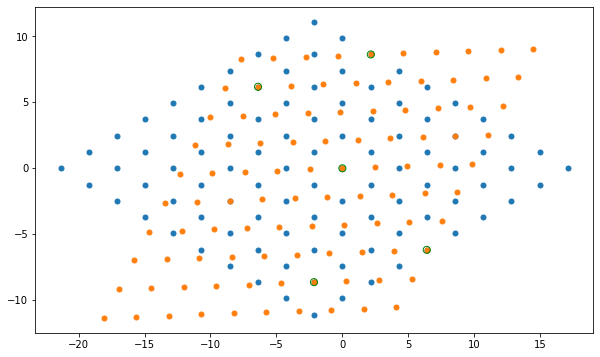

In [ ]:
dim = [5,5]
ar = 2.467;
Alat = ar*np.array([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]]).T
theta_0 = 0.56;
Blat = R(theta_0)@Alat; 

plt.axes().set_aspect('equal')
plt.scatter(*(supercell_points( dim, Alat )), s=25.0)
plt.scatter(*(supercell_points( dim, Blat )), s=25.0)
plt.scatter(*get_supercell_vectors(dim, ref=Blat, target=Alat ), s=50, facecolors='none', edgecolors='g')

cost without otimization -0.07770363434911848
cost after otimization -0.9999999999999991
(s1,s2,theta) (0, 0, 1.5343951027447655)
Supercell Vectors in A [[ 4.05958464e-10 -1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00]]
Supercell Vectors in B [[-1.00000000e+00 -4.76762386e-17]
 [-1.34423200e-16 -1.00000000e+00]]


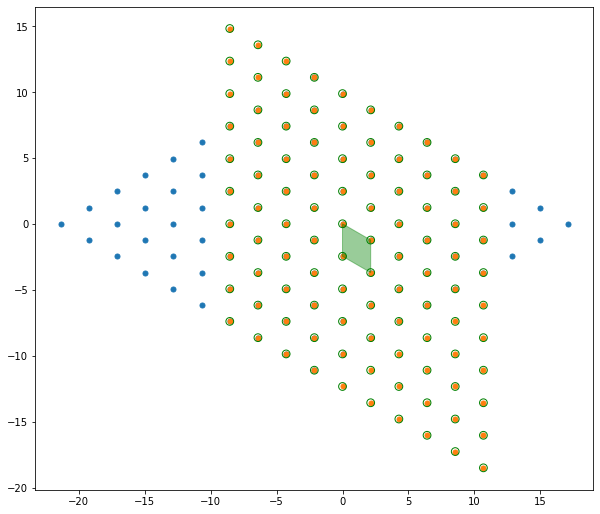

In [ ]:
matcher1= LatMatch(scdim=dim, reference=Alat, target=Blat, optimize_strain=False);
sc_vec = matcher1.supercell();
oBlat  = matcher1.updatedCell();
plt.axes().set_aspect('equal')
plt.scatter(*(supercell_points( dim, Alat )), s=25.0);
plt.scatter(*(supercell_points( dim, oBlat )), s=25.0);
plt.scatter(*get_supercell_vectors(dim, ref=oBlat, target=Alat ), s=60, facecolors='none', edgecolors='g');
# Parallelogram
x = [0.0,sc_vec[0][0],sc_vec[0][0]+sc_vec[0][1],sc_vec[0][1],0.0];
y = [0.0,sc_vec[1][0],sc_vec[1][0]+sc_vec[1][1],sc_vec[1][1],0.0];
plt.gca().add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, alpha=0.4,color="green"))

print("(s1,s2,theta)",matcher1.Result());
print("Supercell Vectors in A", ChangeBasis( sc_vec , Alat));
print("Supercell Vectors in B", ChangeBasis( sc_vec , oBlat));

# Example 2: Strain optimization

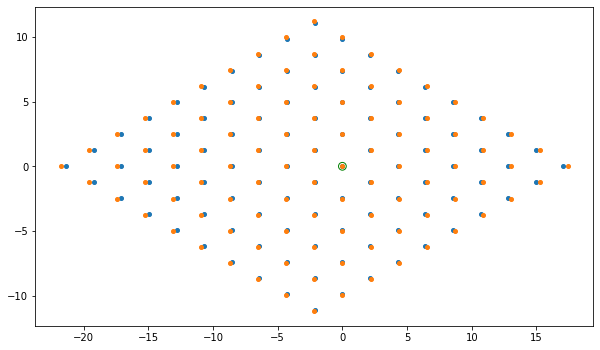

In [ ]:
dim = [5,5]
ar = 2.467;
Alat = ar*np.array([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]]).T
s0,s1 = 0.02,0.01;
Blat = S(s0,s1)@Alat; 

plt.axes().set_aspect('equal');
plt.scatter(*(supercell_points( dim, Alat )), s=16.0);
plt.scatter(*(supercell_points( dim, Blat )), s=16.0);
plt.scatter(*get_supercell_vectors(dim, ref=Blat, target=Alat ), s=60, facecolors='none', edgecolors='g');

cost without otimization -0.3710987316551617
cost after otimization -0.999999999999845
(s1,s2,theta) (-0.01960784813801914, -0.00990099510054512, 0)
Supercell Vectors in A [[ 2.46143233e-11 -9.99999995e-01]
 [-9.99999995e-01  2.46143659e-11]]
Supercell Vectors in B [[ 7.92638596e-17 -1.00000000e+00]
 [-1.00000000e+00  7.92638596e-17]]


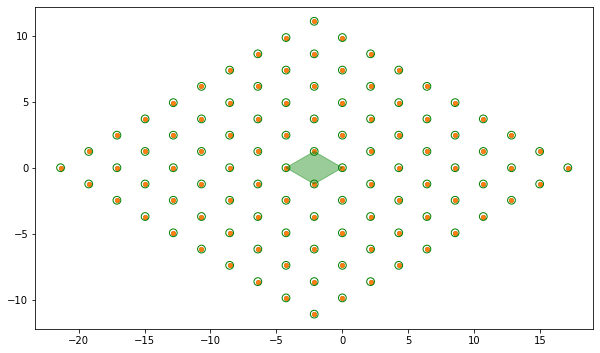

In [ ]:
matcher2 = LatMatch(scdim=dim, reference=Alat, target=Blat, optimize_angle=False);
sc_vec = matcher2.supercell();
oBlat = matcher2.updatedCell();
plt.axes().set_aspect('equal');
plt.scatter(*(supercell_points( dim, Alat )), s=16.0);
plt.scatter(*(supercell_points( dim, oBlat )), s=16.0);
plt.scatter(*get_supercell_vectors(dim, ref=oBlat, target=Alat ), s=60, facecolors='none', edgecolors='g');
# Parallelogram
x = [0.0,sc_vec[0][0],sc_vec[0][0]+sc_vec[0][1],sc_vec[0][1],0.0];
y = [0.0,sc_vec[1][0],sc_vec[1][0]+sc_vec[1][1],sc_vec[1][1],0.0];
plt.gca().add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, alpha=0.4,color="green"))

print("(s1,s2,theta)",matcher2.Result());
print("Supercell Vectors in A", ChangeBasis( sc_vec , Alat));
print("Supercell Vectors in B", ChangeBasis( sc_vec , oBlat));

# Example 3: Twisted bilayer Graphene

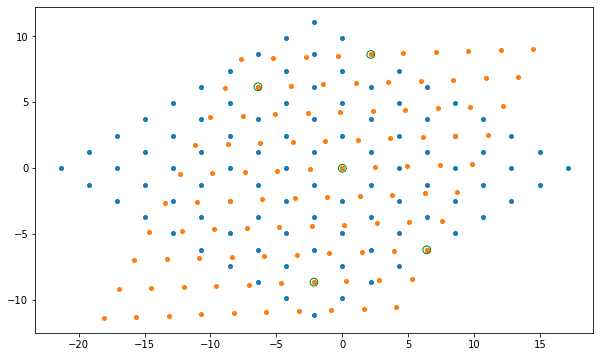

In [ ]:
dim = [5,5]
ar = 2.467;
Alat = ar*np.array([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]]).T
theta_0 = 0.56;
Blat = R(theta_0)@Alat; 

plt.axes().set_aspect('equal');
plt.scatter(*(supercell_points( dim, Alat )), s=16.0);
plt.scatter(*(supercell_points( dim, Blat )), s=16.0);
plt.scatter(*get_supercell_vectors(dim, ref=Blat, target=Alat ), s=60, facecolors='none', edgecolors='g');

cost without otimization -0.07770363434911848
cost after otimization -0.07794883724973563
(s1,s2,theta) (-0.01960784813801914, -0.00990099510054512, 0)
Supercell Vectors in A [[-2.99327437  4.00442492]
 [-1.00625478 -2.99678067]]
Supercell Vectors in B [[-1.  4.]
 [-3. -1.]]


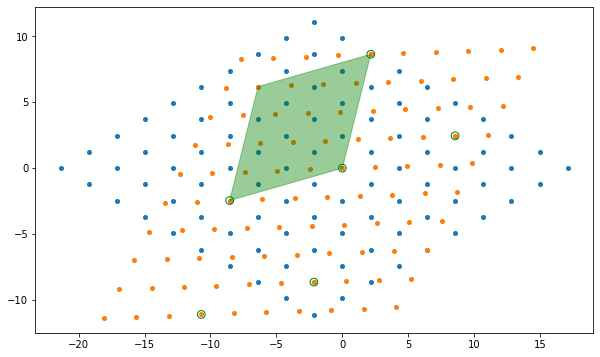

In [ ]:
matcher3 = LatMatch(scdim=dim, reference=Alat, target=Blat, optimize_angle=False);
sc_vec = matcher3.supercell();
oBlat = matcher3.updatedCell();
plt.axes().set_aspect('equal');
plt.scatter(*(supercell_points( dim, Alat )), s=16.0);
plt.scatter(*(supercell_points( dim, oBlat )), s=16.0);
plt.scatter(*get_supercell_vectors(dim, ref=oBlat, target=Alat ), s=60, facecolors='none', edgecolors='g');

# Parallelogram
x = [0.0,sc_vec[0][0],sc_vec[0][0]+sc_vec[0][1],sc_vec[0][1],0.0];
y = [0.0,sc_vec[1][0],sc_vec[1][0]+sc_vec[1][1],sc_vec[1][1],0.0];
plt.gca().add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, alpha=0.4,color="green"))

print("(s1,s2,theta)",matcher2.Result());
print("Supercell Vectors in A", ChangeBasis( sc_vec , Alat));
print("Supercell Vectors in B", ChangeBasis( sc_vec , oBlat));

#Example 4: Heterobilayer

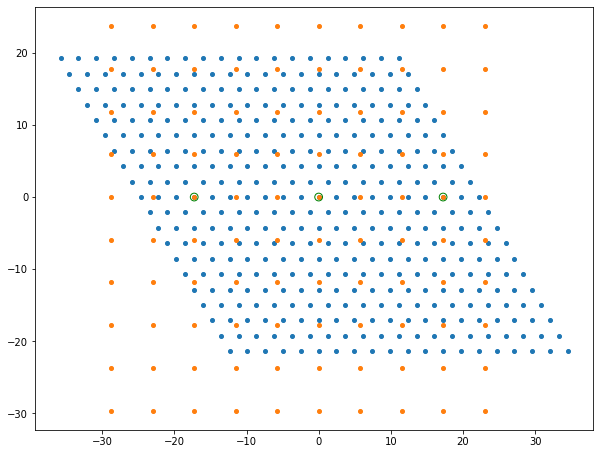

In [ ]:
dim  = [5,5]
dim2 = [10,10]
ar = 2.467;
Alat = ar*np.array([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]])
Alat3D, Aatoms3D = read_xyz("C2.xyz");
Blat3D, Batoms3D = read_xyz("PdSe2.xyz");

Alat = Alat3D[:2,:2].T;
Blat = Blat3D[:2,:2].T; #In the optimization we are using standrs vector notation (not numpy)

plt.axes().set_aspect('equal')
plt.scatter(*(supercell_points( dim2, Alat )), s=16.0)
plt.scatter(*(supercell_points( dim, Blat )), s=16.0)
plt.scatter(*get_supercell_vectors(dim, ref=Blat, target=Alat ), s=60, facecolors='none', edgecolors='g')

cost without otimization -0.02960635025971488
cost after otimization -0.19702348645402307
[[  2.47761127  13.5708781 ]
 [-12.82405127   2.13030358]]
Supercell Vectors in A [[-1.99671521  5.99895506]
 [-6.00184472  0.99701343]]
Supercell Vectors in B [[-2.  1.]
 [-1. -2.]]


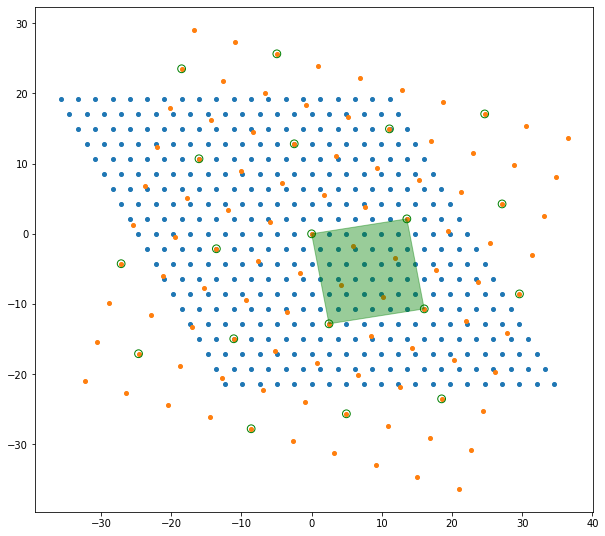

In [ ]:
matcher4= LatMatch(scdim=dim, reference=Alat, target=Blat);

sc_vec = matcher4.supercell();
print(sc_vec)

oBlat  = matcher4.updatedCell();
plt.axes().set_aspect('equal');
plt.scatter(*(supercell_points( dim2, Alat )), s=16.0);
plt.scatter(*(supercell_points( dim, oBlat )), s=16.0);
plt.scatter(*get_supercell_vectors(dim, ref=oBlat, target=Alat ), s=60, facecolors='none', edgecolors='g');

# Parallelogram
x = [0.0,sc_vec[0][0],sc_vec[0][0]+sc_vec[0][1],sc_vec[0][1],0.0];
y = [0.0,sc_vec[1][0],sc_vec[1][0]+sc_vec[1][1],sc_vec[1][1],0.0];
plt.gca().add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, alpha=0.4,color="green"))

print("Supercell Vectors in A", ChangeBasis( sc_vec , Alat));
print("Supercell Vectors in B", ChangeBasis( sc_vec , oBlat));

In [ ]:
import copy
print("(s1,s2,theta)",matcher4.Result());
Tr = np.eye(3);
Tr[:2,:2] = SR(*matcher4.Result());
oBlat3D = copy.copy(Blat3D);
oBlat3D = (Tr@(oBlat3D.T)).T
s, rs = list(zip(*Batoms3D));
rs = [ Tr@r for r in rs ];
oBatoms3D = list(zip(s,rs))

(s1,s2,theta) (0.04456773190588034, 0.008515197124941627, 1.2798425955617287)


(s1,s2,theta) (0.04456773190588034, 0.008515197124941627, 1.2798425955617287)
[[ 0.29965097 -1.0006653 ]
 [ 0.96612803  0.28930872]] [[5.75046067e+00 8.81388393e-20 0.00000000e+00]
 [5.80952532e-19 5.91993496e+00 0.00000000e+00]
 [1.54321371e-18 0.00000000e+00 1.64507399e+01]]


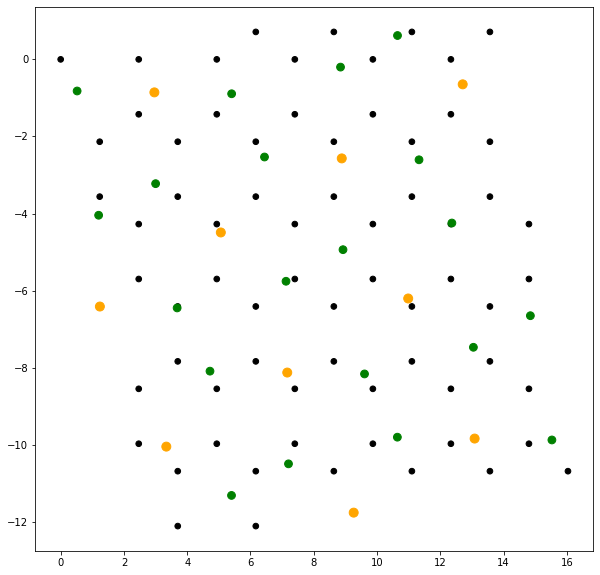

In [ ]:

print("(s1,s2,theta)",matcher4.Result());

Tr = SR(*matcher4.Result());

print(Tr,Blat3D)


#print(Alat3D, Aatoms3D)
A3Dpts,A3Dsym = xyz2supercell(Alat3D, Aatoms3D, (10,10,1));
Apts    = A3Dpts.T[:2]
AinSCpts= ChangeBasis( Apts , sc_vec)
inSC = (np.all(AinSCpts < 1, axis=0) * np.all(AinSCpts >= 0, axis=0)); 
ASCpts= Apts[:,inSC];
ASC3Dpts, ASC3Dsym = A3Dpts[inSC,:],A3Dsym[inSC];

B3Dpts,B3Dsym = xyz2supercell(oBlat3D, oBatoms3D, (10,10,1));
Bpts    = B3Dpts.T[:2]
BinSCpts= ChangeBasis( Bpts , sc_vec)
BSCpts   = BinSCpts[(BinSCpts < 1)*(BinSCpts >= 0)]
BinSCpts= ChangeBasis( Bpts , sc_vec)
inSC = (np.all(BinSCpts < 1, axis=0) * np.all(BinSCpts >= 0, axis=0)); 
BSCpts= Bpts[:,inSC];
BSC3Dpts, BSC3Dsym = B3Dpts[inSC,:],B3Dsym[inSC];

color= {"C":"black", "Pd":"orange", "Se":"green"};
size = {"C":32, "Pd":80, "Se":60};

cA = [ color[s] for s in ASC3Dsym];
SA = [ size[s] for s in ASC3Dsym];


plt.scatter(*(ASC3Dpts.T[:2]), s=SA, c=cA)

cB = [ color[s] for s in BSC3Dsym];
SB = [ size[s] for s in BSC3Dsym];

plt.scatter(*(BSC3Dpts.T[:2]), s=SB, c=cB)

SC3Dpts = np.concatenate( (ASC3Dpts, BSC3Dpts+[0,0,2]));
SC3Dsym = np.concatenate( (ASC3Dsym, BSC3Dsym));

#print(Blat3D, Batoms3D)

(99, 3)


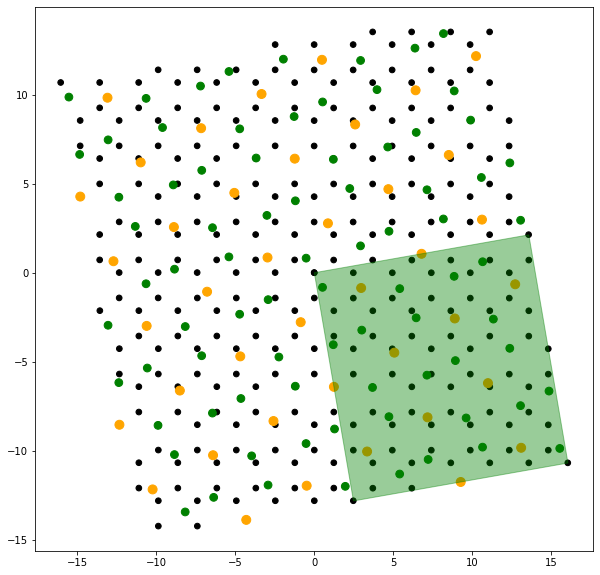

In [ ]:
#c = [ color[s] for s in SC3Dsym];
#S = [ size[s] for s in SC3Dsym];
#plt.scatter(*(SC3Dpts.T[:2]), s=np.array(S)*5, facecolors='none', edgecolors='g')
print(SC3Dpts.shape)


SCatoms = list( zip(SC3Dsym, SC3Dpts ));
SC3dvec = np.eye(3);
SC3dvec[:2,:2] = sc_vec.T;
SC3Dpts,SC3Dsym = xyz2supercell(SC3dvec, SCatoms, (1,1,1));

c = [ color[s] for s in SC3Dsym];
S = [ size[s] for s in SC3Dsym];
plt.scatter(*(SC3Dpts.T[:2]), s=S, c=c)
# Parallelogram
x = [0.0,sc_vec[0][0],sc_vec[0][0]+sc_vec[0][1],sc_vec[0][1],0.0];
y = [0.0,sc_vec[1][0],sc_vec[1][0]+sc_vec[1][1],sc_vec[1][1],0.0];
plt.gca().add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, alpha=0.4,color="green"))



In [ ]:
#conditional points
clat_symbols=[];
clat_points=[];

f = open("gr_pdse2_sc.xyz", "w")
SC3Dpts,SC3Dsym = xyz2supercell(SC3dvec, SCatoms, (1,1,1), no_expand=True);

for symbol,point in zip(SC3Dsym,SC3Dpts):
    if np.linalg.norm(point[:2])<6.0 or True:
        clat_symbols.append(symbol);
        clat_points.append(point);



npoints = len(clat_points)
xyz_out = str(npoints)+"\n";
xyz_out+= "#\t ";
for i,l in enumerate(SC3dvec):
  xyz_out+= "lat_vec"+str(i)+": {} {} {}\t".format(*l);
xyz_out+= "\n";


for symbol,point in zip(clat_symbols,clat_points):
    xyz_out+= "{} {} {} {}\n".format(symbol,*point);


f.write(xyz_out)
f.close()


print(xyz_out)

99
#	 lat_vec0: 2.477611268663281 -12.824051270517877 0.0	lat_vec1: 13.570878099272148 2.130303583458884 0.0	lat_vec2: 0.0 0.0 1.0	
C 3.7008468906470147 -10.683424742723226 7.49999997
C 2.4672312604313427 -8.546739794178581 7.49999997
C 6.16807815107836 -10.683424742723226 7.49999997
C 4.934462520862688 -8.546739794178581 7.49999997
C 3.700846890647016 -6.410054845633936 7.49999997
C 2.467231260431344 -4.273369897089291 7.49999997
C 1.233615630215672 -2.1366849485446453 7.49999997
C 0.0 0.0 7.49999997
C 8.635309411509706 -10.683424742723227 7.49999997
C 7.401693781294034 -8.546739794178581 7.49999997
C 6.168078151078362 -6.410054845633936 7.49999997
C 4.93446252086269 -4.273369897089291 7.49999997
C 3.7008468906470173 -2.1366849485446453 7.49999997
C 2.4672312604313453 -1.7550685731635223e-20 7.49999997
C 11.10254067194105 -10.683424742723227 7.49999997
C 9.86892504172538 -8.546739794178581 7.49999997
C 8.635309411509706 -6.410054845633936 7.49999997
C 7.401693781294035 -4.273369897089

In [ ]:
xyz_out = "#\t ";
for i,l in enumerate(SC3dvec):
  xyz_out+= "lat_vec"+str(i)+": {} {} {}\t".format(*l);
print(xyz_out)

#	 lat_vec0: 2.477611268663281 -12.824051270517877 0.0	lat_vec1: 13.570878099272148 2.130303583458884 0.0	lat_vec2: 0.0 0.0 1.0	


In [ ]:
SC3dvec

array([[  2.47761127, -12.82405127,   0.        ],
       [ 13.5708781 ,   2.13030358,   0.        ],
       [  0.        ,   0.        ,   1.        ]])